# Hito 0 - App Reviewer (Cambiemosle el Nombre)

CC5205 - Minería de Datos

- Profesora: Jazmine Maldonado
- Auxiliar: Fran Zautzik

Integrantes:
- Martín Bravo
- Franco González
- Daniel Radrigrán
- Felipe Valdebenito

## 1. Introducción

En la actualidad, las redes sociales constituyen una de las principales formas de comunicación en el mundo. Algunas de estas redes concentran una cantidad tan grande de personas que las usan, que una alternativa a elas suena como algo impensable. Aún así, algunas corporaciones lanzan su perspectiva de como debiese ser alguna red social en cuestion (séase de ejemplo, la existencia de Telegram frente a WhatsApp como aplicaciones de mensajería instantánea). Dichas redes han sido desarrolladas en base a estudios de mercado, análisis de información, y para este caso, se mencionara el feedback otorgado directamente por los usuarios que conforman la plataforma en sí.

Comercialmente hablando, la retroalimentacion de los usuarios sobre una determinada aplicacion es determinante a la hora de realizar mejoras que atraigan y retengan usuarios dentro de la misma plataforma. Tomando esto en cuenta, dada la gran cantidad de comentarios negativos con descripciones vagas o de exagerada negatividad, se complejiza el poder obtener un feedback objetivo que indique precisamente las falencias de la app. Por estas razones, poder extraer determinados fragmentos que se frecuentan en comentarios negativos es de importancia para ayudar a las empresas a mantener la calidad de sus aplicaciones.

Los datos que se usarán en el proyecto a presentar, corresponden a reviews de usuarios de aplicaciones de redes sociales, en particular, la aplicación Threads. El estudio de estos datos puede permitir el observar que aspectos de las aplicaciones valoran los usuarios. Tambien permite entender las razones del porque no gusta determinada caracteristica. La elección de datos se basa en la relevancia que poseen para el desarrollo de nuevas redes sociales o mejoras de las ya existentes.

Es de particular interés el uso de tecnicas de mineria de datos para obtener los aspectos criticados en las reviews de la app a partir del análisis del lenguaje empleado.

Como bien se ha mencionado, estudiar estos datos nos permite entender cuales son los aspectos a mejorar de una app, los cuales no pueden ser conocidos mediante una simple puntuación numérica (e.g. 1-5 estrellas), pues solo indica el nivel de satisfacción que el usuario tiene sobre la app, sin otorgar detalle sobre la razón de dicha calificación.

## 2. Exploración de Datos

Por medio del uso de Python, junto con variadas librerias para la manipulación del dataset escogido, se procedera a la obtención de tablas y gráficos para extraer información general sobre los comentarios dados a la aplicación Threads. Dicha aplicación se basa en la publicación de mensajes breves a modo de que cada usuario participa en "foros" según los tópicos más importantes del día.

In [30]:
# Librerías

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import string # string manipulation
import re # regular expressions
import nltk # text manipulation

from tqdm import trange # progress bar
from nltk import tokenize # text manipulation
from nltk.corpus import stopwords # text manipulation
from nltk.stem import WordNetLemmatizer # text manipulation
from nltk.probability import FreqDist # text manipulation
from collections import Counter # text manipulation
from sklearn.feature_extraction.text import CountVectorizer # text manipulation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # wordcloud generator
from IPython.display import display # image display
from PIL import Image

En primer lugar se mostrará una vista preliminar del dataset escogido. Para ver cantidad de columnas y los tipos de datos que se manejan:

In [31]:
data = pd.read_csv("threads.csv") # carga del dataset a usar como variable
data.head()

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43


Dicho dataset cuenta con 4 columnas, y 32910 filas. Las columnas son:
- Source: La procedencia de los comentarios (según el sistema operativo y la tienda de aplicaciones de la cual se descargó),
- Review Description: El comentario publicado, el cual contiene el detalle sobre la calificación otorgada a la aplicación.
- Rating: La puntuación otorgada, en una escala de 1 a 5, con 1 como puntuacion mala y 5 como excelente.
- Review Date: Fecha de publicación de la reseña, con detalle sobre el día, mes, año y hora de publicación.

Se hará una revisión a la cantidad de reseñas segun la calificación otorgada:

In [32]:
print(data["rating"].value_counts()) # contar la cantidad de reviews recibidas segun el rating de 1 a 5

# muestra mediana, media, desviación estándar, mínimo y máximo de la variable "replies"
data.describe()

rating
5    15559
1     9726
4     3244
3     2585
2     1796
Name: count, dtype: int64


,rating
count,32910.000000
mean,3.398481
std,1.751480
min,1.000000
25%,1.000000
50%,4.000000
75%,5.000000
max,5.000000


Podemos ver que el promedio de los ratings es de 3.4, lo cual es un valor bastante bajo, además podemos observar que la mayoría de reseñas son de 5 estrellas, y luego vienen las de 1 estrella, esto nos sugiere dividir las reseñas en distintos grupos.

A partir de estos datos, se puede generar un gráfico de pastel. Primero, se realizará una conversión del rating según rangos. Dichos rangos son: 1-2 estrellas como NEGATIVO, 3-4  estrellas como NEUTRAL y 5 estrellas como POSITIVO. El gráfico generado se muestra a continuación.

La razón de esta elección es debido a que los comentarios de 1-2 estrellas suelen ser de tipos negativos, mientras que los de 5 estrellas suelen ser positivos. Los comentarios de 3-4 estrellas los pondremos como neutrales, ya que dicen algo positivo de la aplicación, pero también mencionan algo negativo (en un principio dejamos neutral como 3 estrellas pero esto generaba muy poca cantidad de reseñas neutrales).

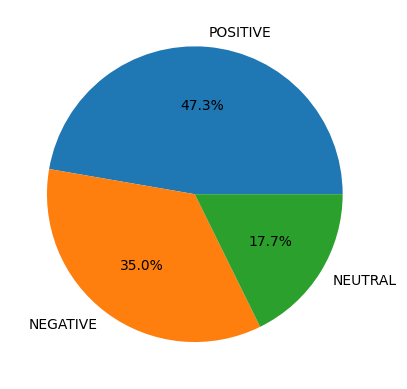

In [33]:
# función para convertir el rating a palabras
def ratingTransform(rating):
    if rating <= 2:
        return "NEGATIVE"
    elif rating <= 4:
        return "NEUTRAL"
    else:
        return "POSITIVE"

# creacion del grafico de pie de las reviews segun rating
data["rating"] = data["rating"].apply(ratingTransform)
plt.pie(data["rating"].value_counts(), labels=data["rating"].value_counts().index, autopct='%1.1f%%')
plt.show() 

Podemos ver que la mayoría de las reseñas son positivas, luego vienen las negativas y por último las neutrales. Esto nos sugiere que la aplicación es buena, pero tiene algunos problemas que se pueden mejorar.

Ya que nuestro dataset contiene en su mayoría texto, generaremos columnas que nos ayuden a analizarlo. Estas columnas serán:
- Review Length: Cantidad de palabras que contiene el comentario.
- Word Count: Cantidad de palabras que contiene el comentario.
- Mean Word Length: Promedio de largo de las palabras del comentario.
- Mean Sentence Length: Promedio de largo de las oraciones del comentario.

Estas columnas nos ayudarán a realizar gráficos basados en atributos provenientes del texto.

In [34]:
# tabla generada con el largo en caracteres de las reviews escritas
data['Length'] = data['review_description'].str.len()

# numero de palabras en la primera revie del dataset
word_count = data['review_description'][0].split()

# funcion para separar una oracion y contar la cantidad de palabras que posee
def word_count(review):
    review_list = review.split()
    return len(review_list)

# generacion de nueva columna de cantidad de palabras por review
data['Word_count'] = data['review_description'].apply(word_count)

# largo promedio de las palabras en cada review
data['mean_word_length'] = data['review_description'].map(lambda rev: np.mean([len(word) for word in rev.split()]))

# largo promedio de las oraciones en cada review
np.mean([len(sent) for sent in tokenize.sent_tokenize(data['review_description'][0])])
data['mean_sent_length'] = data['review_description'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))

data.head(10)

,source,review_description,rating,review_date,Length,Word_count,mean_word_length,mean_sent_length
0,Google Play,Meh. Not the greatest experience on a Chromebo...,NEGATIVE,2023-07-08 14:18:24,465,85,4.482353,65.571429
1,Google Play,Pretty good for a first launch!! Its easy to u...,NEUTRAL,2023-07-19 20:52:48,475,81,4.876543,157.666667
2,Google Play,"For a brand new app, it's very well optimized....",NEUTRAL,2023-07-06 23:03:11,497,91,4.472527,70.142857
3,Google Play,"Great app with a lot of potential! However, th...",NEUTRAL,2023-07-10 00:53:25,487,94,4.191489,80.333333
4,Google Play,"The app is good, but it needs a lot of functio...",NEUTRAL,2023-07-06 16:57:43,426,79,4.405063,84.400000
5,Google Play,"Currently, it's very challenging to use. It's ...",NEGATIVE,2023-07-18 22:30:10,386,75,4.160000,47.375000
6,Google Play,I still don’t want to see content from people ...,NEGATIVE,2023-07-19 19:35:31,438,81,4.419753,86.800000
7,Google Play,Could be great if all pages loaded when you cl...,NEGATIVE,2023-07-06 14:35:15,365,67,4.462687,60.000000
8,Google Play,I'm liking the concept! There is room for impr...,NEUTRAL,2023-07-09 03:27:39,416,86,3.848837,40.700000
9,Google Play,Not bad! This is its first launch. There is st...,POSITIVE,2023-07-06 23:41:13,328,55,4.981818,46.000000


['Length', 'Word_count', 'mean_word_length', 'mean_sent_length']



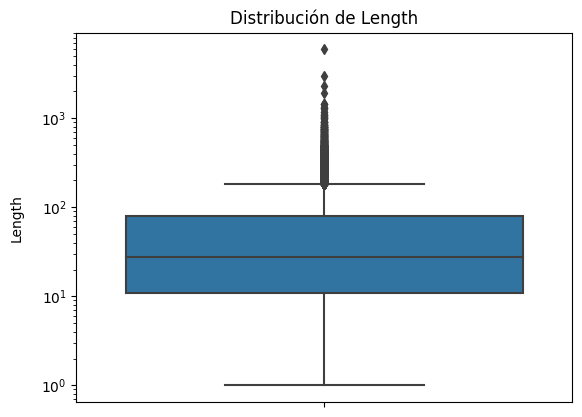

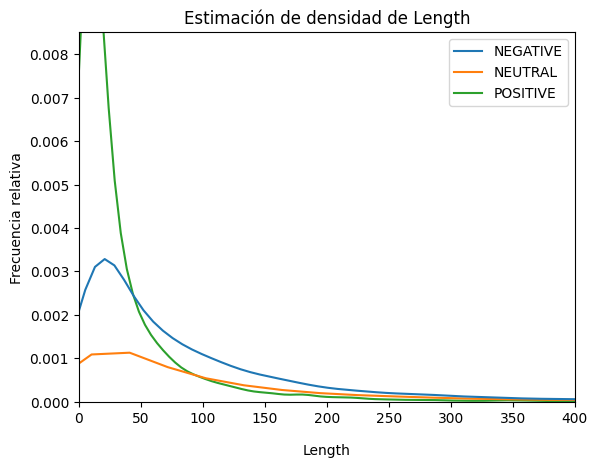

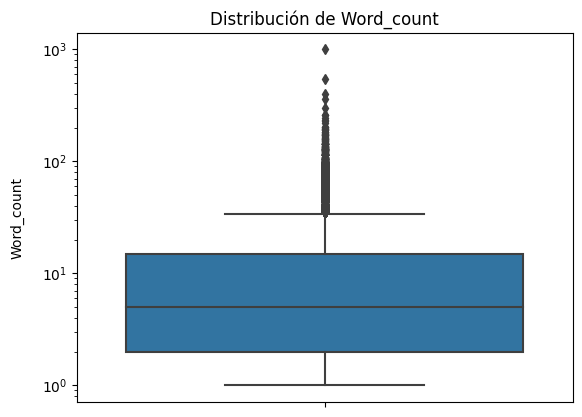

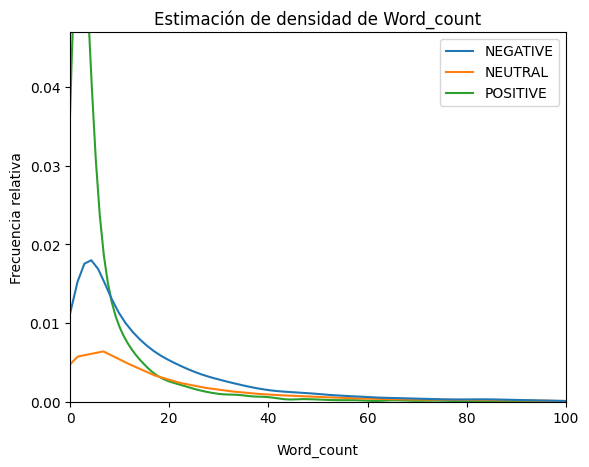

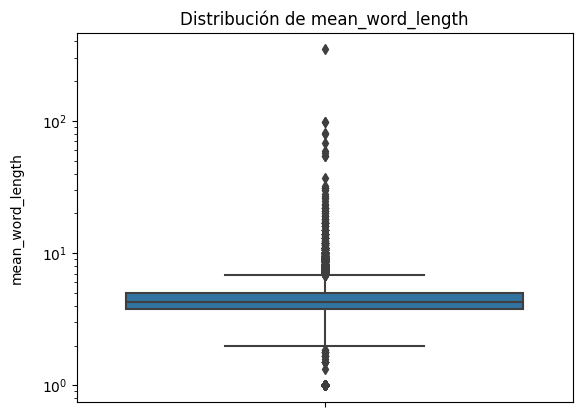

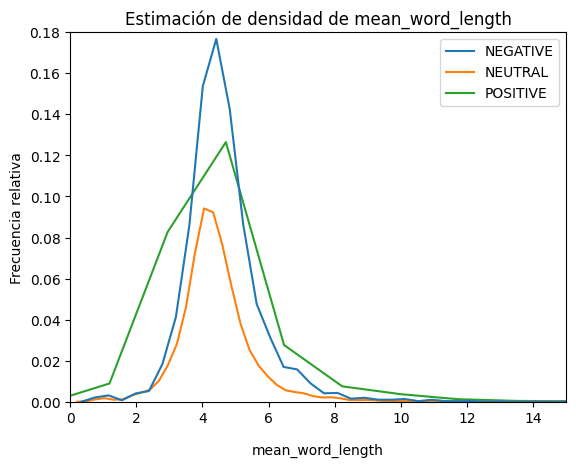

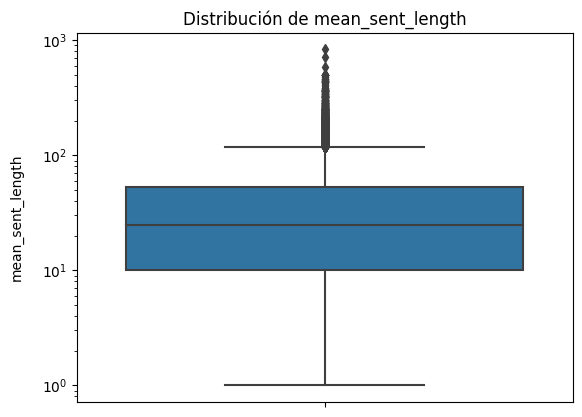

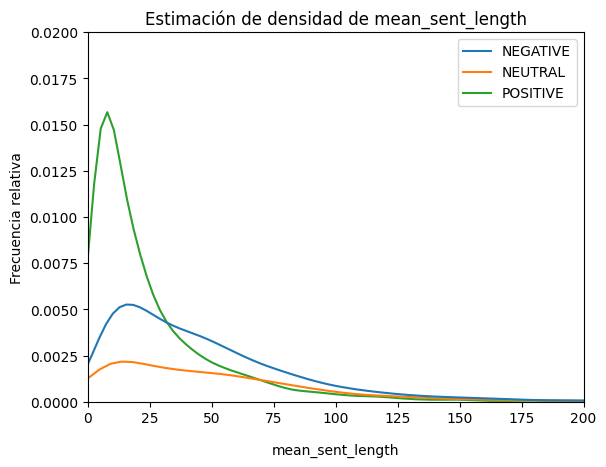

In [35]:
# creacion del boxplot de las palabras
def visualize(col, ind=0, max_ys=[0.0085,0.047,0.18,0.02], max_xs=[400,100,15,200]):
    
    print()
    plt.plot(1,2,1)
    sns.boxplot(y=data[col], hue=data['rating'])
    plt.title('Distribución de '+col)
    plt.ylabel(col, labelpad=12.5)
    plt.yscale('log') 
    plt.show()
    
    plt.plot(1,2,2)
    sns.kdeplot(data=data, x=col, hue='rating')
    plt.legend(data['rating'].unique())
    plt.ylim([0,max_ys[ind]])
    plt.xlim([0,max_xs[ind]])
    plt.title('Estimación de densidad de '+col)
    plt.xlabel(col, labelpad=12.5)
    plt.ylabel('Frecuencia relativa')
    
    
    
    plt.show()

features = data.columns.tolist()[4:]
print(features)
i = 0
for feature in features:
    visualize(feature,i)
    i+=1

### Analisis de frecuencia de términos

Haremos uso de la librería NLTK, la cual nos permite realizar un análisis de frecuencia de términos. Para esto, primero debemos limpiar el texto, eliminando signos de puntuación, números, stopwords, etc. Esto lo hace gracias a que internamente NLTK posee una lista de stopwords en inglés, la cual usaremos para eliminarlas. Además, usaremos la librería string para eliminar signos de puntuación y números.

In [36]:
def clean(review):
    
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review

data['review_description'] = data['review_description'].apply(clean)

pasamos las reviews a una lista de strings

In [ ]:
def corpus(text):
    text_list = text.split()
    return text_list

data['review_lists'] = data['review_description'].apply(corpus)
data.head(10)

In [ ]:
corpus = []
for i in trange(data.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += data['review_lists'][i]
len(corpus)

10 palabras mas comunes

In [ ]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

In [ ]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

sns.barplot(x=freq, y=words)
plt.title('Top 10 Palabras más comunes')
plt.show()

In [ ]:
# generacion de la wordcloud para definir cuales pueden ser las palabras mas importantes
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

### Los $N-$ gramas mas frecuentes

Los $N-$ gramas son secuencias de $N$ palabras consecutivas en un texto.

In [ ]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data['review_description'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 2-gramas más comunes')
plt.show()

In [ ]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(data['review_description'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 3-gramas más comunes')
plt.show()

## 3. Preguntas y Problemas

Dada la exploración anterior y su motivación original,
formular preguntas que se pueden responder mediante la minería de datos y que
se puedan vincular a la problemática planteada en la motivación.

Ejemplos:
1. ¿Es posible predecir la variable X en función de Y, Z, K?
2. ¿Existen grupos importantes de ejemplos que se comporten de
manera similar de acuerdo a algún criterio?
3. ¿Existen asociaciones frecuentes inesperadas entre grupos de
atributos?

1. ¿Existe una asociacion entre las personas que comparan threads con twiter y una puntuacion negativa?\n",
2. ¿Es posible predecir si una reseña es positiva dado ciertos N-gramas?"
3. ¿Que palabras se asocian a una reseña positiva?
4. ¿Cuales palabras se asocian a una reseña negativa?
5. ¿Hay diferencias entre las reseñas positivas y negativas en palabras usadas, tamnaño de las reseñas, etc.?
6. ¿Cómo se puede determinar el impacto de una actualización de una aplicación mediante las reseñas de usuarios?